# Data Validation and Cleaning - patched

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/rsna_classification/train_jpg/train_jpg"
print("Exists:", os.path.exists(DATA_DIR))

# Try listing 5 files only (less chance of Drive choking)
try:
    print("Sample:", os.listdir(DATA_DIR)[:5])
except Exception as e:
    print("Error:", e)


Exists: True
Sample: ['ID_65725d1b3.jpg', 'ID_65728d71f.jpg', 'ID_6572aa651.jpg', 'ID_65734b850.jpg', 'ID_657373ec6.jpg']


In [ ]:
# SETUP (run after mounting Drive)
!pip install -q albumentations timm pyarrow
PROJECT_DIR = r"/content/drive/MyDrive/rsna_classification"
META_DIR = r"/content/drive/MyDrive/rsna_classification/meta/meta"
DATA_DIR = r"/content/drive/MyDrive/rsna_classification/train_jpg/train_jpg"
print('PROJECT_DIR:', PROJECT_DIR)
print('META_DIR   :', META_DIR)
print('DATA_DIR   :', DATA_DIR)


PROJECT_DIR: /content/drive/MyDrive/rsna_classification
META_DIR   : /content/drive/MyDrive/rsna_classification/meta/meta
DATA_DIR   : /content/drive/MyDrive/rsna_classification/train_jpg/train_jpg


In [ ]:
# Load metadata and build filenames + label columns
import pandas as pd, os
candidates=['labels.fth','comb.fth','df_trn.fth','df_tst.fth']
labels_path=None
for c in candidates:
    p=os.path.join(META_DIR,c)
    if os.path.exists(p):
        labels_path=p
        break
if labels_path is None:
    raise FileNotFoundError('No metadata file found in META_DIR: ' + str(META_DIR))
print('Using meta file:', labels_path)
df = pd.read_feather(labels_path)
print('Original meta rows:', len(df))
if 'ID' in df.columns:
    df['filename'] = df['ID'].astype(str) + '.jpg'
    LABEL_COLS = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
else:
    if 'fname' in df.columns:
        df['filename'] = df['fname'].apply(lambda x: os.path.basename(x))
    LABEL_COLS = [c for c in ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'] if c in df.columns]
print('Label columns:', LABEL_COLS)
# keep only rows that have an actual image in DATA_DIR
existing = set([f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))])
print('Found images in DATA_DIR:', len(existing))
old = len(df)
df = df[df['filename'].isin(existing)].reset_index(drop=True)
print('Cleaned df rows:', len(df), 'removed:', old - len(df))
# save cleaned metadata for future use
clean_path = os.path.join(META_DIR, 'labels_cleaned.fth')
df.to_feather(clean_path)
print('Saved cleaned metadata to:', clean_path)
# show sample
print(df.head())


Using meta file: /content/drive/MyDrive/rsna_classification/meta/meta/labels.fth
Original meta rows: 674258
Label columns: ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
Found images in DATA_DIR: 78257
Cleaned df rows: 78257 removed: 596001
Saved cleaned metadata to: /content/drive/MyDrive/rsna_classification/meta/meta/labels_cleaned.fth
             ID  any  epidural  intraparenchymal  intraventricular  \
0  ID_00008ce3c    0         0                 0                 0   
1  ID_0000aee4b    0         0                 0                 0   
2  ID_0002003a8    0         0                 0                 0   
3  ID_0002081b6    1         0                 1                 0   
4  ID_00027cbb1    0         0                 0                 0   

   subarachnoid  subdural          filename  
0             0         0  ID_00008ce3c.jpg  
1             0         0  ID_0000aee4b.jpg  
2             0         0  ID_0002003a8.jpg  
3             

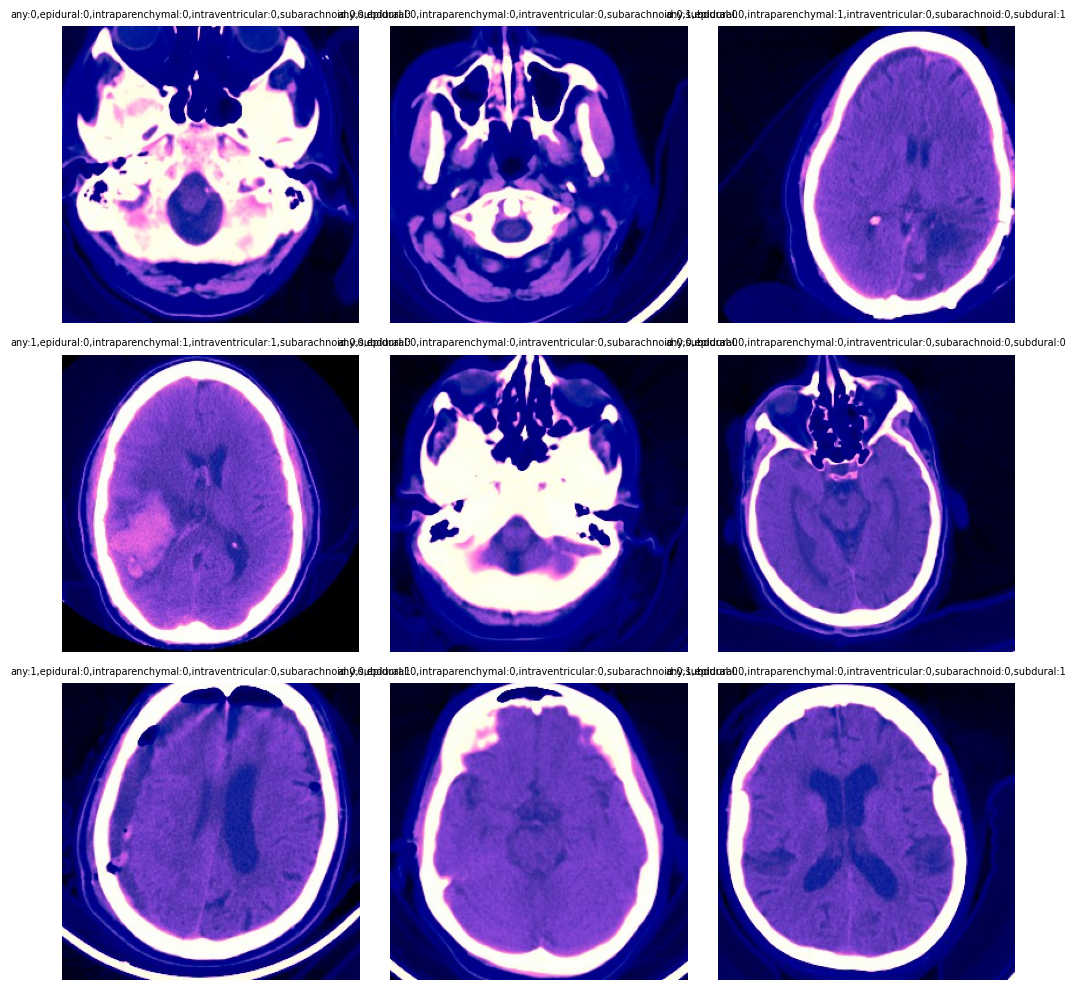

any 39287
epidural 1128
intraparenchymal 13130
intraventricular 9693
subarachnoid 13035
subdural 17065


In [ ]:
# Visualize samples (skip unreadable)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
sample = df.sample(12).reset_index(drop=True)
plt.figure(figsize=(10,10))
shown = 0
for i, row in sample.iterrows():
    p = os.path.join(DATA_DIR, row['filename'])
    try:
        img = Image.open(p).convert('RGB')
    except Exception:
        print('Skipping unreadable:', row['filename'])
        continue
    shown += 1
    plt.subplot(3,3,shown)
    plt.imshow(np.array(img))
    plt.title(','.join([f"{c}:{int(row[c])}" for c in LABEL_COLS]), fontsize=7)
    plt.axis('off')
    if shown==9:
        break
plt.tight_layout(); plt.show()
for c in LABEL_COLS: print(c, df[c].sum())
